This script generates the plots to compare SCITE-RNA, DENDRO and SClineager on simulated datasets with a variable number of ground truth clones. Additionally, it plots a comparison of the runtimes.

In [82]:
import numpy as np
import dendropy
from dendropy.calculate import treecompare
import warnings
import matplotlib.pyplot as plt

import json
import os
from matplotlib.patches import Patch

import matplotlib.ticker as mticker
from matplotlib.font_manager import FontProperties
from sklearn.metrics import adjusted_rand_score

from src_python.cell_tree import CellTree
from src_python.utils import load_config_and_set_random_seed, path_len_dist, mut_count_distance

In [83]:
path = r"D:\PhD\SCITERNA\simulated_data" #../data/simulated_data"
path_consensus = "../data/results"

n_cells = [50]
n_mut = [500]
n_tests = 100
clones = ["", "5", "10", "20"]

n_round = 1

config = load_config_and_set_random_seed()

use_summary_statistics = False # Uses the summary files saved in the data_summary/ directory. If raw output files were generated, set to False

models = [
    "SCITE-RNA",
    "SCITE-RNA-clustered",
    "SCITE-RNA-consensus",
    "SClineager",
    "DENDRO",
    "PhylinSic"
]

# Initialize all metrics as empty dictionaries
genotype_differences = {}
path_len_differences = {}
mut_count_differences = {}
rf_differences = {}
quartet_differences = {}
adjusted_rand_index = {}

# List of metrics
metrics = [genotype_differences, path_len_differences, mut_count_differences, rf_differences, quartet_differences,adjusted_rand_index]

for metric in metrics:
    for model in models:
        metric[model] = {}

In [84]:
def to_newick(ct, node):
    if ct.isleaf(node):
        return f"{node}"
    children = ct.children(node)
    return "(" + ",".join(to_newick(ct, child) for child in children) + f"){node}"

In [85]:
if not use_summary_statistics:
    for n_c, n_m in zip(n_cells, n_mut):

        path_len_differences["SCITE-RNA"][f"{n_c}_{n_m}"] = {}
        genotype_differences["SCITE-RNA"][f"{n_c}_{n_m}"] = {}
        mut_count_differences["SCITE-RNA"][f"{n_c}_{n_m}"] = {}
        rf_differences["SCITE-RNA"][f"{n_c}_{n_m}"] = {}

        for clone in clones:
            vaf_differences = []
            path_len_distances = []
            mut_count_distances = []
            rf_distances = []

            for t in range(n_tests):
                base_path = os.path.join(path, f"{n_c}c{n_m}m{clone}")
                genotype_pred_path = os.path.join(base_path, "sciterna", "sciterna_genotype", f"sciterna_genotype_{n_round}r{t}.txt")
                genotype_path = os.path.join(base_path, "genotype", f"genotype_{t}.txt")
                genotype_pred = np.loadtxt(genotype_pred_path, dtype=str)
                genotype_gt = np.loadtxt(genotype_path, dtype=str)

                true_parent_vec = np.loadtxt(os.path.join(base_path, "parent_vec", f"parent_vec_{t}.txt"), dtype=int)
                sciterna_parent_vec = np.loadtxt(os.path.join(base_path, "sciterna", "sciterna_parent_vec", f"sciterna_parent_vec_{n_round}r{t}.txt"), dtype=int)

                mapping_dict = {'A': 1.0, 'H': 0.5, 'R': 0}
                vectorized_map = np.vectorize(lambda x: float(mapping_dict[x]))
                genotype_predicted = vectorized_map(genotype_pred)
                genotype_gt = vectorized_map(genotype_gt)
                unique_genotypes = np.unique(genotype_gt, axis=0)

                difference = np.mean(np.abs(genotype_predicted - genotype_gt))
                vaf_differences.append(difference)

                ct_gt = CellTree(n_c)
                ct_sciterna = CellTree(n_c, flipped_mutation_direction=True)

                ct_gt.use_parent_vec(true_parent_vec)
                ct_sciterna.use_parent_vec(sciterna_parent_vec)

                path_len_distances.append(path_len_dist(ct_gt, ct_sciterna))
                mut_count_distances.append(mut_count_distance(genotype_gt, genotype_predicted))

                newick1 = to_newick(ct_gt, ct_gt.main_root) + ";"
                newick2 = to_newick(ct_sciterna, ct_sciterna.main_root) + ";"
                taxa = dendropy.TaxonNamespace([str(i) for i in range(n_c)])
                tree1 = dendropy.Tree.get(data=newick1, schema="newick", taxon_namespace=taxa)
                tree2 = dendropy.Tree.get(data=newick2, schema="newick", taxon_namespace=taxa)

                rf_distances.append(treecompare.unweighted_robinson_foulds_distance(tree1, tree2))

            path_len_differences["SCITE-RNA"][f"{n_c}_{n_m}"][clone] = path_len_distances
            genotype_differences["SCITE-RNA"][f"{n_c}_{n_m}"][clone] = vaf_differences
            mut_count_differences["SCITE-RNA"][f"{n_c}_{n_m}"][clone] = mut_count_distances
            rf_differences["SCITE-RNA"][f"{n_c}_{n_m}"][clone] = rf_distances

            print(np.mean(path_len_distances), " mean path length distance")
            print(np.mean(vaf_differences), " mean abs difference of vafs predicted")
            print(np.mean(mut_count_distances), " mean mutation count distance")
            print(np.nanmean(rf_distances), " mean Robinson-Foulds distance")

2.3880163265306122  mean path length distance
0.030648000000000005  mean abs difference of vafs predicted
11.563787755102041  mean mutation count distance
75.68  mean Robinson-Foulds distance
4.887208163265306  mean path length distance
0.034108999999999993  mean abs difference of vafs predicted
40.69462040816327  mean mutation count distance
84.52  mean Robinson-Foulds distance
3.6361714285714286  mean path length distance
0.0327506  mean abs difference of vafs predicted
28.118571428571418  mean mutation count distance
75.68  mean Robinson-Foulds distance
2.4828979591836733  mean path length distance
0.03191580000000001  mean abs difference of vafs predicted
22.624220408163268  mean mutation count distance
64.84  mean Robinson-Foulds distance


In [86]:
if not use_summary_statistics:
    for n_c, n_m in zip(n_cells, n_mut):
        path_len_differences["SCITE-RNA-consensus"][f"{n_c}_{n_m}"] = {}
        rf_differences["SCITE-RNA-consensus"][f"{n_c}_{n_m}"] = {}

        for clone in clones:
            path_len_distances = []
            rf_distances = []

            for t in range(n_tests):
                base_path = os.path.join(path, f"{n_c}c{n_m}m{clone}")
                base_path_consensus = os.path.join(path_consensus, f"{n_c}c{n_m}m{clone}")
                true_parent_vec = np.loadtxt(os.path.join(base_path, "parent_vec", f"parent_vec_{t}.txt"), dtype=int)
                sciterna_parent_vec = np.loadtxt(os.path.join(base_path_consensus,  "sciterna_consensus_parent_vec", f"sciterna_parent_vec_{n_round}r{t}.txt"), dtype=int)

                ct_gt = CellTree(n_c)
                ct_sciterna = CellTree(n_c, flipped_mutation_direction=True)

                ct_gt.use_parent_vec(true_parent_vec)
                ct_sciterna.use_parent_vec(sciterna_parent_vec)

                path_len_distances.append(path_len_dist(ct_gt, ct_sciterna))

                newick1 = to_newick(ct_gt, ct_gt.main_root) + ";"
                newick2 = to_newick(ct_sciterna, ct_sciterna.main_root) + ";"
                taxa = dendropy.TaxonNamespace([str(i) for i in range(n_c)])
                tree1 = dendropy.Tree.get(data=newick1, schema="newick", taxon_namespace=taxa)
                tree2 = dendropy.Tree.get(data=newick2, schema="newick", taxon_namespace=taxa)

                rf_distances.append(treecompare.unweighted_robinson_foulds_distance(tree1, tree2))

            path_len_differences["SCITE-RNA-consensus"][f"{n_c}_{n_m}"][clone] = path_len_distances
            rf_differences["SCITE-RNA-consensus"][f"{n_c}_{n_m}"][clone] = rf_distances
            print(np.mean(path_len_distances), " mean path length distance")
            print(np.nanmean(rf_distances), " mean Robinson-Foulds distance")

2.2206367346938776  mean path length distance
72.9  mean Robinson-Foulds distance
4.076481632653061  mean path length distance
83.86  mean Robinson-Foulds distance
3.384653061224489  mean path length distance
73.82  mean Robinson-Foulds distance
2.4992897959183673  mean path length distance
61.56  mean Robinson-Foulds distance


In [87]:
if not use_summary_statistics:
    for n_c, n_m in zip(n_cells, n_mut):
        genotype_differences["SCITE-RNA-clustered"][f"{n_c}_{n_m}"] = {}
        path_len_differences["SCITE-RNA-clustered"][f"{n_c}_{n_m}"] = {}
        mut_count_differences["SCITE-RNA-clustered"][f"{n_c}_{n_m}"] = {}
        adjusted_rand_index["SCITE-RNA-clustered"][f"{n_c}_{n_m}"] = {}
        rf_differences["SCITE-RNA-clustered"][f"{n_c}_{n_m}"] = {}
        for clone in clones:
            vaf_differences = []
            path_len_distances = []
            mut_count_distances = []
            adjusted_rand_scores = []
            rf_distances = []
            for t in range(n_tests):
                base_path = os.path.join(path, f"{n_c}c{n_m}m{clone}")

                genotype_gt = np.loadtxt(os.path.join(base_path, "genotype", f"genotype_{t}.txt"), dtype=str).T

                if genotype_gt.ndim == 1:
                    genotype_gt = genotype_gt[:, np.newaxis]

                _, clones_gt = np.unique(genotype_gt, axis=1, return_inverse=True)

                clones_pred_path = os.path.join(base_path, "sciterna", "sciterna_clones", f"sciterna_clones_{t}.txt")
                clones_pred = np.loadtxt(clones_pred_path, dtype=float)
                if len(clones_pred) != n_c:
                    print("Cells were filtered out, skipping this test")
                    continue
                adjusted_rand_scores.append(adjusted_rand_score(clones_gt, clones_pred))

                ref_path = os.path.join(base_path, "ref", f"ref_{t}.txt")
                alt_path = os.path.join(base_path, "alt", f"alt_{t}.txt")
                true_parent_vec = np.loadtxt(os.path.join(base_path, "parent_vec", f"parent_vec_{t}.txt"), dtype=int)
                sciterna_parent_vec = np.loadtxt(os.path.join(base_path, "sciterna", "sciterna_parent_vec_clustering", f"sciterna_parent_vec_clustering_{t}.txt"), dtype=int)

                alt = np.loadtxt(alt_path)
                ref = np.loadtxt(ref_path)
                alt_t = alt.T
                ref_t = ref.T

                with np.errstate(invalid='ignore'):
                    vaf_observed = alt_t/(alt_t + ref_t)

                mapping_dict = {'A': 1.0, 'H': 0.5, 'R': 0}
                vectorized_map = np.vectorize(lambda x: float(mapping_dict[x]))
                genotype_gt = vectorized_map(genotype_gt)

                unique_classes = np.unique(clones_pred)

                # For each unique class, replace column values with the mean of the columns of that class
                for cls in unique_classes:
                    class_indices = np.where(clones_pred == cls)[0]
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore", category=RuntimeWarning)
                        mean_values = np.nanmean(vaf_observed[:, class_indices], axis=1)

                    # in case the mean is nan replace it with the mean genotype over all cells
                    row_nanmean = np.nanmean(vaf_observed, axis=1)
                    if np.isnan(row_nanmean).any():
                        raise ValueError("Error: The array contains NaN values.")
                    mean_values = np.where(np.isnan(mean_values), row_nanmean, mean_values)
                    if np.isnan(mean_values).any():
                        raise ValueError("Error: The array contains NaN values.")

                    vaf_observed[:, class_indices] = np.tile(mean_values[:, np.newaxis], len(class_indices))


                genotype_predicted = np.round(vaf_observed * 2) / 2
                if np.isnan(genotype_predicted).any():
                    print("Error: The array contains NaN values.")

                vaf_difference = np.mean(np.abs(genotype_predicted - genotype_gt))
                vaf_differences.append(vaf_difference)

                ct_gt = CellTree(n_c)
                ct_sciterna = CellTree(n_c)

                ct_gt.use_parent_vec(true_parent_vec)
                ct_sciterna.use_parent_vec(sciterna_parent_vec)

                path_len_distances.append(path_len_dist(ct_gt, ct_sciterna))
                mut_count_distances.append(mut_count_distance(genotype_gt, genotype_predicted))

                newick1 = to_newick(ct_gt, ct_gt.main_root) + ";"
                newick2 = to_newick(ct_sciterna, ct_sciterna.main_root) + ";"
                taxa = dendropy.TaxonNamespace([str(i) for i in range(n_c)])
                tree1 = dendropy.Tree.get(data=newick1, schema="newick", taxon_namespace=taxa)
                tree2 = dendropy.Tree.get(data=newick2, schema="newick", taxon_namespace=taxa)

                rf_distances.append(treecompare.unweighted_robinson_foulds_distance(tree1, tree2))


            genotype_differences["SCITE-RNA-clustered"][f"{n_c}_{n_m}"][clone] = vaf_differences
            path_len_differences["SCITE-RNA-clustered"][f"{n_c}_{n_m}"][clone] = path_len_distances
            mut_count_differences["SCITE-RNA-clustered"][f"{n_c}_{n_m}"][clone] = mut_count_distances
            adjusted_rand_index["SCITE-RNA-clustered"][f"{n_c}_{n_m}"][clone] = adjusted_rand_scores
            rf_differences["SCITE-RNA-clustered"][f"{n_c}_{n_m}"][clone] = rf_distances
            print(np.mean(vaf_differences), " mean abs difference of vafs predicted")
            print(np.mean(path_len_distances), " mean path length distance")
            print(np.mean(mut_count_distances), " mean mutation count distance")
            print(np.mean(adjusted_rand_scores), " mean adjusted rand index")
            print(np.nanmean(rf_distances), " mean Robinson-Foulds distance")

0.0675508  mean abs difference of vafs predicted
3.5893877551020403  mean path length distance
4.516865170340681  mean mutation count distance
1.0  mean adjusted rand index
82.54  mean Robinson-Foulds distance
0.0501416  mean abs difference of vafs predicted
4.209836734693877  mean path length distance
4.876157835671342  mean mutation count distance
0.4864087198943913  mean adjusted rand index
85.14  mean Robinson-Foulds distance
0.0794224  mean abs difference of vafs predicted
3.9233632653061226  mean path length distance
6.325736032064131  mean mutation count distance
0.448898661930177  mean adjusted rand index
80.82  mean Robinson-Foulds distance
0.09255079999999999  mean abs difference of vafs predicted
3.5360244897959183  mean path length distance
6.191681042084168  mean mutation count distance
0.4214693242006576  mean adjusted rand index
75.28  mean Robinson-Foulds distance


In [88]:
if not use_summary_statistics:
    for n_c, n_m in zip(n_cells, n_mut):
        genotype_differences["PhylinSic"][f"{n_c}_{n_m}"] = {}
        path_len_differences["PhylinSic"][f"{n_c}_{n_m}"] = {}
        mut_count_differences["PhylinSic"][f"{n_c}_{n_m}"] = {}
        rf_differences["PhylinSic"][f"{n_c}_{n_m}"] = {}
        for clone in clones:
            vaf_differences = []
            path_len_distances = []
            mut_count_distances = []
            rf_distances = []
            for t in range(n_tests):
                base_path = os.path.join(path, f"{n_c}c{n_m}m{clone}")

                genotype_gt = np.loadtxt(os.path.join(base_path, "genotype", f"genotype_{t}.txt"), dtype=str).T
                genotype_predicted = np.loadtxt(os.path.join(base_path, "phylinsic", "phylinsic_genotype", f"phylinsic_genotype_{t}.txt"), dtype=str)[1:]

                true_parent_vec = np.loadtxt(os.path.join(base_path, "parent_vec", f"parent_vec_{t}.txt"), dtype=int)
                phylinsic_parent_vec = np.loadtxt(os.path.join(base_path, "phylinsic", "phylinsic_parent_vec", f"phylinsic_parent_vec_{t}.txt"), dtype=int)

                mapping_dict = {'A': 1.0, 'H': 0.5, 'R': 0}
                vectorized_map = np.vectorize(lambda x: float(mapping_dict[x]))
                genotype_gt = vectorized_map(genotype_gt)
                genotype_predicted = vectorized_map(genotype_predicted)

                if genotype_predicted.shape != genotype_gt.shape:
                    print("Cells or mutations were filtered out")
                    continue

                vaf_difference = np.mean(np.abs(genotype_predicted - genotype_gt))
                vaf_differences.append(vaf_difference)

                ct_gt = CellTree(n_c)
                ct_phylinsic = CellTree(n_c)

                ct_gt.use_parent_vec(true_parent_vec)
                ct_phylinsic.use_parent_vec(phylinsic_parent_vec)

                path_len_distances.append(path_len_dist(ct_gt, ct_phylinsic))
                mut_count_distances.append(mut_count_distance(genotype_gt, genotype_predicted))

                newick1 = to_newick(ct_gt, ct_gt.main_root) + ";"
                newick2 = to_newick(ct_phylinsic, ct_phylinsic.main_root) + ";"
                taxa = dendropy.TaxonNamespace([str(i) for i in range(n_c)])
                tree1 = dendropy.Tree.get(data=newick1, schema="newick", taxon_namespace=taxa)
                tree2 = dendropy.Tree.get(data=newick2, schema="newick", taxon_namespace=taxa)

                rf_distances.append(treecompare.unweighted_robinson_foulds_distance(tree1, tree2))

            genotype_differences["PhylinSic"][f"{n_c}_{n_m}"][clone] = vaf_differences
            path_len_differences["PhylinSic"][f"{n_c}_{n_m}"][clone] = path_len_distances
            mut_count_differences["PhylinSic"][f"{n_c}_{n_m}"][clone] = mut_count_distances
            rf_differences["PhylinSic"][f"{n_c}_{n_m}"][clone] = rf_distances
            print(np.mean(vaf_differences), " mean abs difference of vafs predicted")
            print(np.mean(path_len_distances), " mean path length distance")
            print(np.mean(mut_count_distances), " mean mutation count distance")
            print(np.nanmean(rf_distances), " mean Robinson-Foulds distance")

0.09176639999999998  mean abs difference of vafs predicted
4.264800000000001  mean path length distance
5.798757034068137  mean mutation count distance
91.68  mean Robinson-Foulds distance
0.11988019999999999  mean abs difference of vafs predicted
4.058628571428572  mean path length distance
6.185779318637275  mean mutation count distance
85.3  mean Robinson-Foulds distance
0.11947959999999998  mean abs difference of vafs predicted
3.588636734693878  mean path length distance
6.103814749499  mean mutation count distance
83.46  mean Robinson-Foulds distance
0.12024799999999997  mean abs difference of vafs predicted
3.3175428571428567  mean path length distance
6.051564408817637  mean mutation count distance
84.34  mean Robinson-Foulds distance


In [89]:
if not use_summary_statistics:
    for n_c, n_m in zip(n_cells, n_mut):
        genotype_differences["SClineager"][f"{n_c}_{n_m}"] = {}
        path_len_differences["SClineager"][f"{n_c}_{n_m}"] = {}
        mut_count_differences["SClineager"][f"{n_c}_{n_m}"] = {}
        adjusted_rand_index["SClineager"][f"{n_c}_{n_m}"] = {}
        rf_differences["SClineager"][f"{n_c}_{n_m}"] = {}
        for clone in clones:
            vaf_differences = []
            path_len_distances = []
            mut_count_distances = []
            adjusted_rand_scores = []
            rf_distances = []
            for t in range(n_tests):
                base_path = os.path.join(path, f"{n_c}c{n_m}m{clone}")

                genotype_gt = np.loadtxt(os.path.join(base_path, "genotype", f"genotype_{t}.txt"), dtype=str).T
                vaf_predicted = np.loadtxt(os.path.join(base_path, "sclineager", "sclineager_vaf", f"sclineager_vaf_{t}.txt"), dtype=float).T

                if genotype_gt.ndim == 1:
                    genotype_gt = genotype_gt[:, np.newaxis]

                _, clones_gt = np.unique(genotype_gt, axis=1, return_inverse=True)

                clones_pred_path = os.path.join(base_path, "sclineager", "sclineager_clones", f"sclineager_clones_{t}.txt")
                clones_pred = np.loadtxt(clones_pred_path, dtype=float)

                adjusted_rand_scores.append(adjusted_rand_score(clones_gt, clones_pred))

                true_parent_vec = np.loadtxt(os.path.join(base_path, "parent_vec", f"parent_vec_{t}.txt"), dtype=int)
                sclineager_parent_vec = np.loadtxt(os.path.join(base_path, "sclineager", "sclineager_parent_vec", f"sclineager_parent_vec_{t}.txt"), dtype=int)

                mapping_dict = {'A': 1.0, 'H': 0.5, 'R': 0}
                vectorized_map = np.vectorize(lambda x: float(mapping_dict[x]))
                genotype_gt = vectorized_map(genotype_gt)

                genotype_predicted = np.round(vaf_predicted * 2) / 2
                if genotype_predicted.shape != genotype_gt.shape:
                    print("Cells or mutations were filtered out")
                    continue
                vaf_difference = np.mean(np.abs(genotype_predicted - genotype_gt))
                vaf_differences.append(vaf_difference)

                ct_gt = CellTree(n_c)
                ct_sclineager = CellTree(n_c)

                ct_gt.use_parent_vec(true_parent_vec)
                ct_sclineager.use_parent_vec(sclineager_parent_vec)

                path_len_distances.append(path_len_dist(ct_gt, ct_sclineager))
                mut_count_distances.append(mut_count_distance(genotype_gt, genotype_predicted))

                newick1 = to_newick(ct_gt, ct_gt.main_root) + ";"
                newick2 = to_newick(ct_sclineager, ct_sclineager.main_root) + ";"
                taxa = dendropy.TaxonNamespace([str(i) for i in range(n_c)])
                tree1 = dendropy.Tree.get(data=newick1, schema="newick", taxon_namespace=taxa)
                tree2 = dendropy.Tree.get(data=newick2, schema="newick", taxon_namespace=taxa)

                rf_distances.append(treecompare.unweighted_robinson_foulds_distance(tree1, tree2))

            genotype_differences["SClineager"][f"{n_c}_{n_m}"][clone] = vaf_differences
            path_len_differences["SClineager"][f"{n_c}_{n_m}"][clone] = path_len_distances
            mut_count_differences["SClineager"][f"{n_c}_{n_m}"][clone] = mut_count_distances
            adjusted_rand_index["SClineager"][f"{n_c}_{n_m}"][clone] = adjusted_rand_scores
            rf_differences["SClineager"][f"{n_c}_{n_m}"][clone] = rf_distances
            print(np.mean(vaf_differences), " mean abs difference of vafs predicted")
            print(np.mean(path_len_distances), " mean path length distance")
            print(np.mean(mut_count_distances), " mean mutation count distance")
            print(np.mean(adjusted_rand_scores), " mean adjusted rand index")
            print(np.mean(rf_distances), " mean Robinson-Foulds distance")

Cells or mutations were filtered out
Cells or mutations were filtered out
0.06781040816326529  mean abs difference of vafs predicted
4.65280299875052  mean path length distance
4.986736820579935  mean mutation count distance
1.0  mean adjusted rand index
92.75510204081633  mean Robinson-Foulds distance
0.0830922  mean abs difference of vafs predicted
4.552383673469388  mean path length distance
6.206450501002005  mean mutation count distance
0.3317912039866646  mean adjusted rand index
91.64  mean Robinson-Foulds distance
Cells or mutations were filtered out
Cells or mutations were filtered out
Cells or mutations were filtered out
0.08662969072164947  mean abs difference of vafs predicted
4.517845571218179  mean path length distance
5.97734652810776  mean mutation count distance
0.1767862859073336  mean adjusted rand index
91.91752577319588  mean Robinson-Foulds distance
Cells or mutations were filtered out
Cells or mutations were filtered out
0.08843040816326529  mean abs difference o

In [90]:
if not use_summary_statistics:
    for n_c, n_m in zip(n_cells, n_mut):
        genotype_differences["DENDRO"][f"{n_c}_{n_m}"] = {}
        path_len_differences["DENDRO"][f"{n_c}_{n_m}"] = {}
        mut_count_differences["DENDRO"][f"{n_c}_{n_m}"] = {}
        adjusted_rand_index["DENDRO"][f"{n_c}_{n_m}"] = {}
        rf_differences["DENDRO"][f"{n_c}_{n_m}"] = {}
        for clone in clones:
            vaf_differences = []
            path_len_distances = []
            mut_count_distances = []
            adjusted_rand_scores = []
            rf_distances = []
            for t in range(n_tests):
                base_path = os.path.join(path, f"{n_c}c{n_m}m{clone}")

                genotype_gt = np.loadtxt(os.path.join(base_path, "genotype", f"genotype_{t}.txt"), dtype=str).T

                if genotype_gt.ndim == 1:
                    genotype_gt = genotype_gt[:, np.newaxis]

                _, clones_gt = np.unique(genotype_gt, axis=1, return_inverse=True)

                clones_pred_path = os.path.join(base_path, "dendro", "dendro_clones", f"dendro_clones_{t}.txt")
                clones_pred = np.loadtxt(clones_pred_path, dtype=float)
                if len(clones_pred) != n_c:
                    print("Cells were filtered out, skipping this test")
                    continue
                adjusted_rand_scores.append(adjusted_rand_score(clones_gt, clones_pred))

                ref_path = os.path.join(base_path, "ref", f"ref_{t}.txt")
                alt_path = os.path.join(base_path, "alt", f"alt_{t}.txt")
                true_parent_vec = np.loadtxt(os.path.join(base_path, "parent_vec", f"parent_vec_{t}.txt"), dtype=int)

                dendro_parent_vec = np.loadtxt(os.path.join(base_path, "dendro", "dendro_parent_vec", f"dendro_parent_vec_{t}.txt"), dtype=int)

                alt = np.loadtxt(alt_path)
                ref = np.loadtxt(ref_path)
                alt_t = alt.T
                ref_t = ref.T

                with np.errstate(invalid='ignore'):
                    vaf_observed = alt_t/(alt_t + ref_t)

                mapping_dict = {'A': 1.0, 'H': 0.5, 'R': 0}
                vectorized_map = np.vectorize(lambda x: float(mapping_dict[x]))
                genotype_gt = vectorized_map(genotype_gt)

                unique_classes = np.unique(clones_pred)

                # For each unique class, replace column values with the mean of the columns of that class
                for cls in unique_classes:
                    class_indices = np.where(clones_pred == cls)[0]
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore", category=RuntimeWarning)
                        mean_values = np.nanmean(vaf_observed[:, class_indices], axis=1)

                    # in case the mean is nan replace it with the mean genotype over all cells
                    row_nanmean = np.nanmean(vaf_observed, axis=1)
                    if np.isnan(row_nanmean).any():
                        raise ValueError("Error: The array contains NaN values.")
                    mean_values = np.where(np.isnan(mean_values), row_nanmean, mean_values)
                    if np.isnan(mean_values).any():
                        raise ValueError("Error: The array contains NaN values.")

                    vaf_observed[:, class_indices] = np.tile(mean_values[:, np.newaxis], len(class_indices))


                genotype_predicted = np.round(vaf_observed * 2) / 2
                if np.isnan(genotype_predicted).any():
                    print("Error: The array contains NaN values.")

                vaf_difference = np.mean(np.abs(genotype_predicted - genotype_gt))
                vaf_differences.append(vaf_difference)

                ct_gt = CellTree(n_c)
                ct_dendro = CellTree(n_c)

                ct_gt.use_parent_vec(true_parent_vec)
                ct_dendro.use_parent_vec(dendro_parent_vec)

                path_len_distances.append(path_len_dist(ct_gt, ct_dendro))
                mut_count_distances.append(mut_count_distance(genotype_gt, genotype_predicted))

                newick1 = to_newick(ct_gt, ct_gt.main_root) + ";"
                newick2 = to_newick(ct_dendro, ct_dendro.main_root) + ";"
                taxa = dendropy.TaxonNamespace([str(i) for i in range(n_c)])
                tree1 = dendropy.Tree.get(data=newick1, schema="newick", taxon_namespace=taxa)
                tree2 = dendropy.Tree.get(data=newick2, schema="newick", taxon_namespace=taxa)

                rf_distances.append(treecompare.unweighted_robinson_foulds_distance(tree1, tree2))


            genotype_differences["DENDRO"][f"{n_c}_{n_m}"][clone] = vaf_differences
            path_len_differences["DENDRO"][f"{n_c}_{n_m}"][clone] = path_len_distances
            mut_count_differences["DENDRO"][f"{n_c}_{n_m}"][clone] = mut_count_distances
            adjusted_rand_index["DENDRO"][f"{n_c}_{n_m}"][clone] = adjusted_rand_scores
            rf_differences["DENDRO"][f"{n_c}_{n_m}"][clone] = rf_distances
            print(np.mean(vaf_differences), " mean abs difference of vafs predicted")
            print(np.mean(path_len_distances), " mean path length distance")
            print(np.mean(mut_count_distances), " mean mutation count distance")
            print(np.mean(adjusted_rand_scores), " mean adjusted rand index")
            print(np.mean(rf_distances), " mean Robinson-Foulds distance")

0.0675508  mean abs difference of vafs predicted
4.732391836734695  mean path length distance
4.516865170340681  mean mutation count distance
1.0  mean adjusted rand index
93.06  mean Robinson-Foulds distance
0.0751738  mean abs difference of vafs predicted
4.659591836734694  mean path length distance
5.61423254509018  mean mutation count distance
0.23567379134374583  mean adjusted rand index
92.16  mean Robinson-Foulds distance
0.10883880000000003  mean abs difference of vafs predicted
4.6629632653061215  mean path length distance
6.6394586773547095  mean mutation count distance
0.09482540200326817  mean adjusted rand index
92.36  mean Robinson-Foulds distance
0.11349439999999998  mean abs difference of vafs predicted
4.608440816326531  mean path length distance
6.325874789579157  mean mutation count distance
0.05038498739179565  mean adjusted rand index
92.5  mean Robinson-Foulds distance


In [91]:
if use_summary_statistics:
    with open("../data_summary/simulated_data/genotype_differences.json", "r") as f:
        genotype_differences = json.load(f)
    with open("../data_summary/simulated_data/path_len_differences.json", "r") as f:
        path_len_differences = json.load(f)
    with open("../data_summary/simulated_data/adjusted_rand_index.json", "r") as f:
        adjusted_rand_index = json.load(f)
    with open("../data_summary/simulated_data/runtimes.json", "r") as f:
        runtime_data = json.load(f)

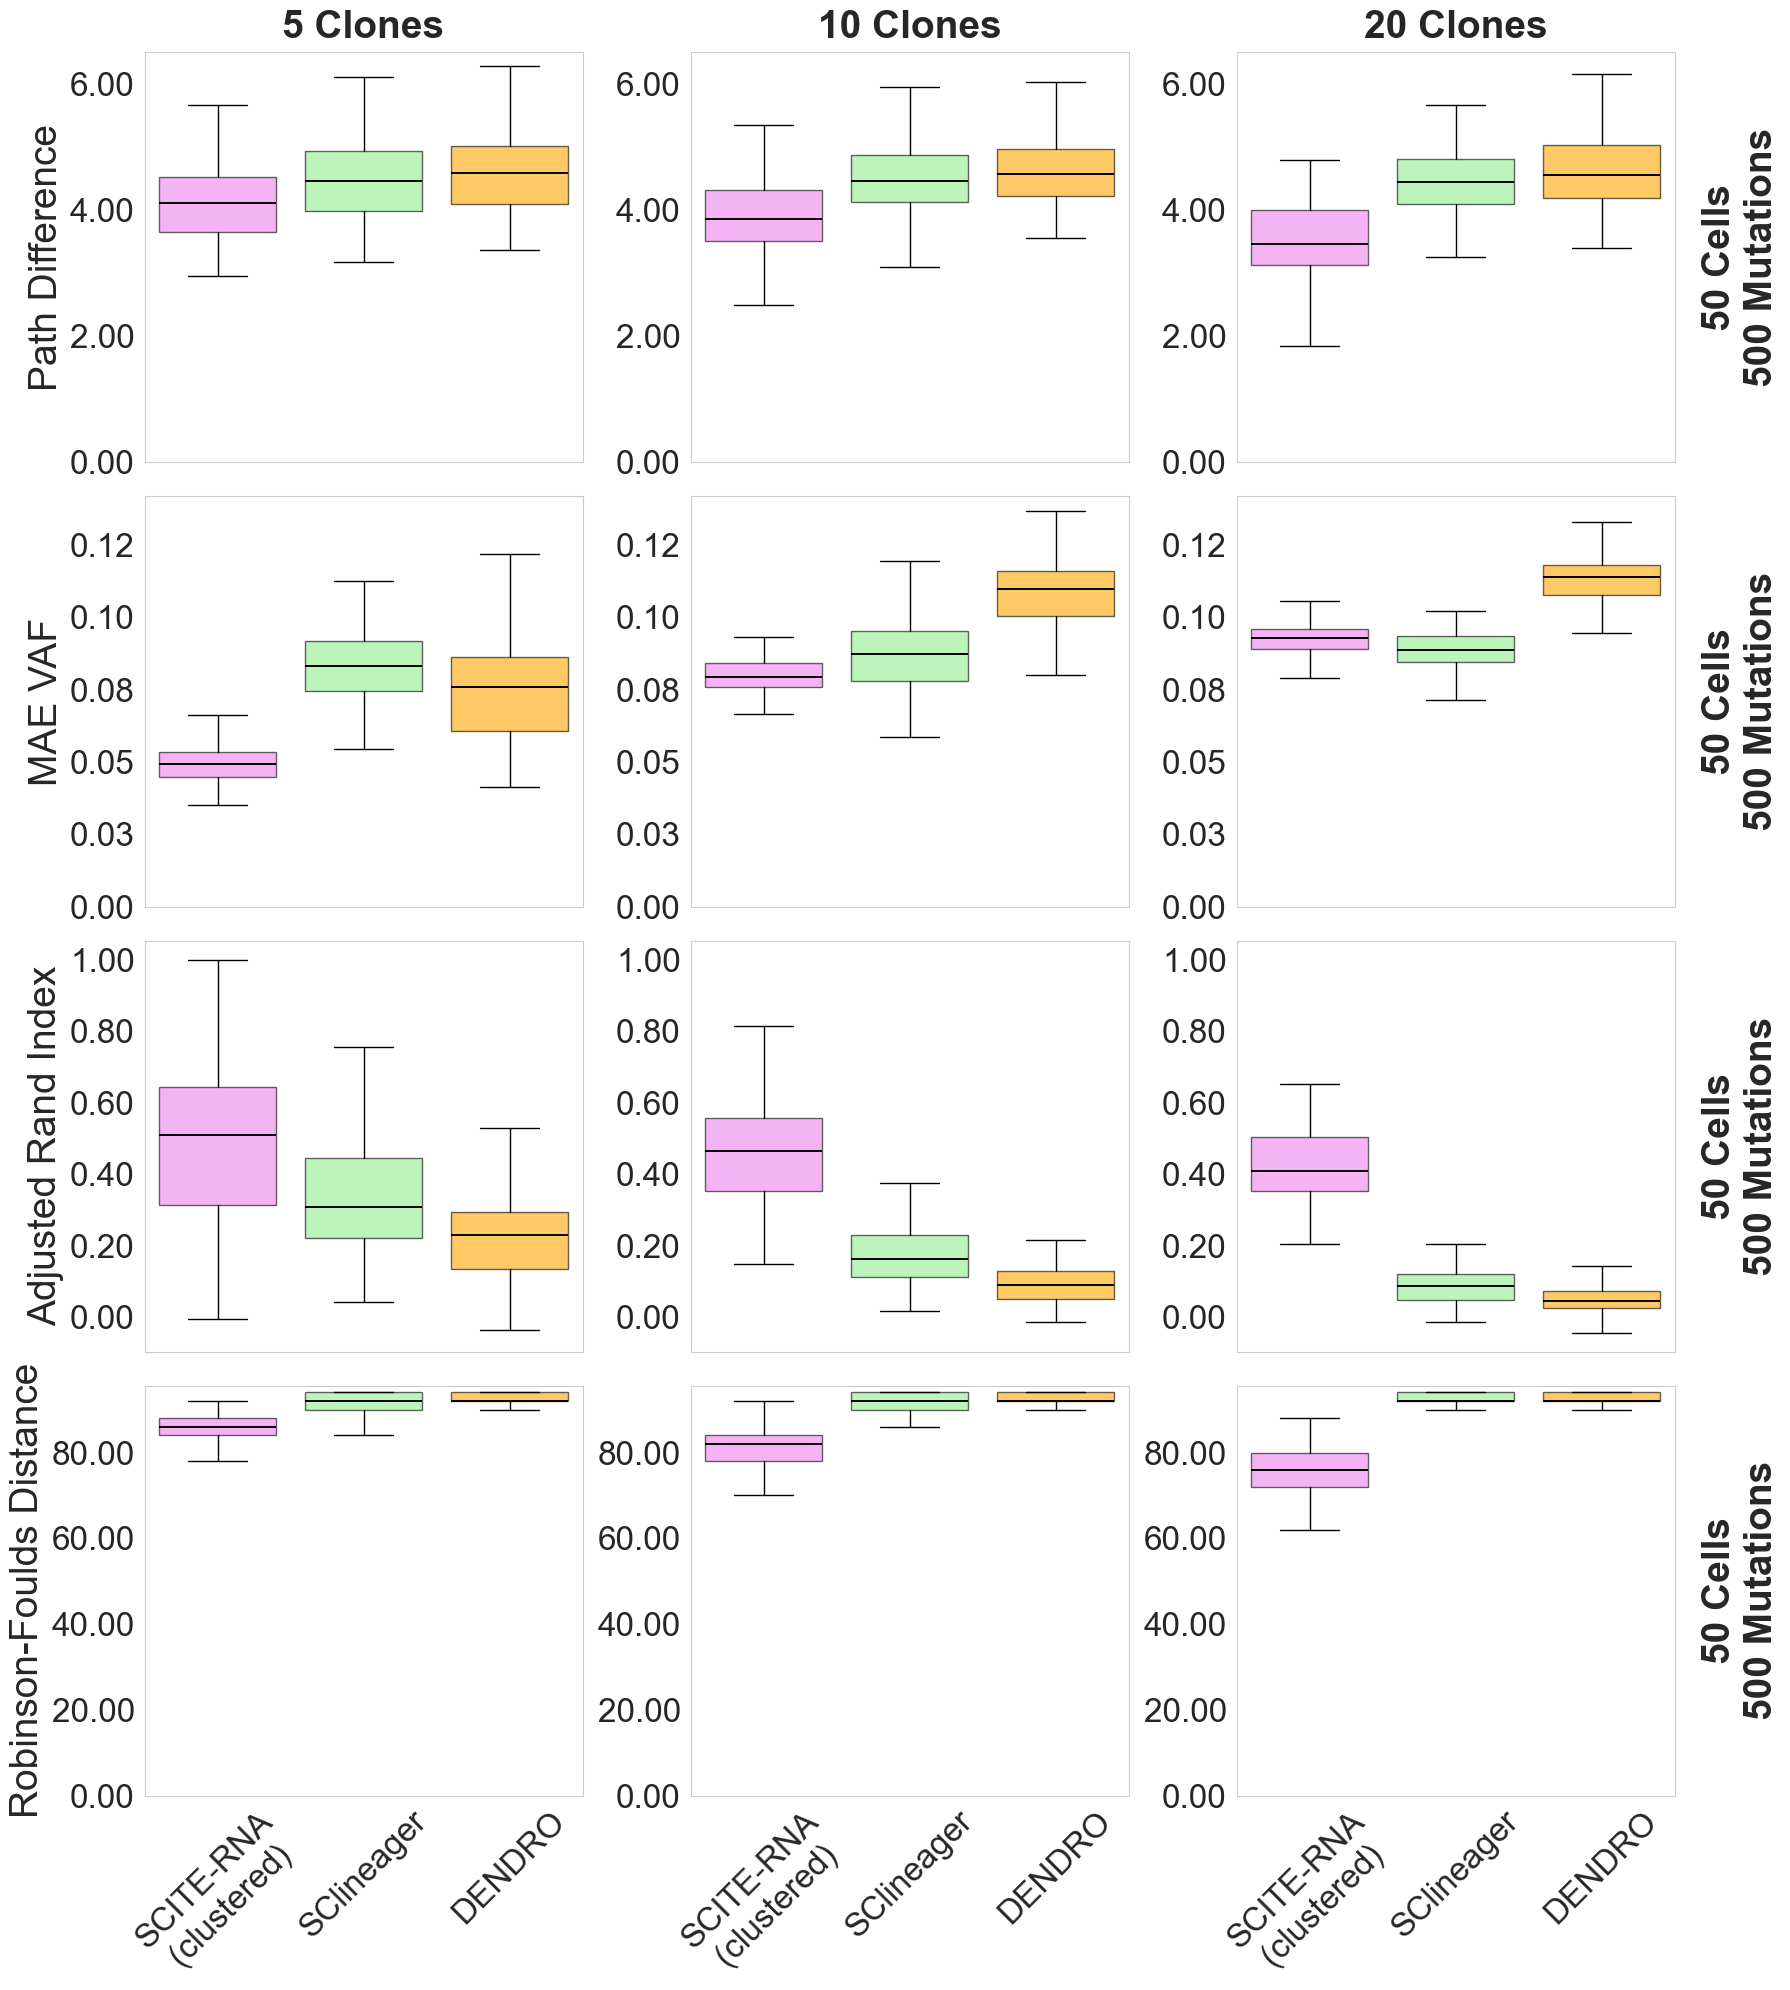

In [106]:
def plot_combined_vaf_pathlength(data_list, clones, models=["SCITE-RNA-clustered", "SClineager", "DENDRO"]):

    n_c, n_m = 50, 500
    rows = len(data_list)
    cols = len(clones)
    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows), sharey=False)

    if rows == 1 or cols == 1:
        axes = np.expand_dims(axes, axis=0)

    colors = ["violet", "lightgreen", "orange"]
    alpha_value = 0.6
    title_size = 28
    label_size = 28
    tick_size = 24
    box_width = 1.4
    boxplot_widths = 0.8
    plot_titles = ["Path Difference", "MAE VAF", "Adjusted Rand Index", "Robinson-Foulds Distance"]

    for row_idx, (data, plot_title) in enumerate(zip(data_list, plot_titles)):
        row_whiskers = []
        for col_idx, clone in enumerate(clones):
            sample_key = f"{n_c}_{n_m}"
            ax = axes[row_idx, col_idx]

            all_samples = [data[model][sample_key][clone] for model in models]
            box = ax.boxplot(all_samples, patch_artist=True, widths=boxplot_widths, showfliers=False)

            for patch, color in zip(box['boxes'], colors):
                patch.set_facecolor(color)
                patch.set_alpha(alpha_value)

            for line in box['medians']:
                line.set_linewidth(box_width)
                line.set_color("black")

            whisker_data = np.concatenate([line.get_ydata() for line in box['whiskers']])
            row_whiskers.append(whisker_data)

            # Set titles on the top row
            if row_idx == 0:
                ax.set_title(f"{clone} Clones", fontsize=title_size, pad=10, fontweight="bold")

            if row_idx == rows - 1:
                custom_labels = [
                    "SCITE-RNA\n(clustered)",
                    "SClineager",
                    "DENDRO"
                ]
                ax.set_xticks(range(1, len(models) + 1))
                ax.set_xticklabels(custom_labels, fontsize=tick_size, rotation=90, ha='center', va='top')
            else:
                ax.set_xticks([])

            if col_idx == 0:
                ax.set_ylabel(plot_title, fontsize=label_size)

            if col_idx == cols - 1:
                ax.yaxis.set_label_position("right")
                ax.set_ylabel(f"{n_c} Cells\n{n_m} Mutations",
                              fontsize=label_size,
                              rotation=90, labelpad=20,
                              fontproperties=FontProperties(weight='bold'))

            ax.tick_params(axis='x', labelsize=tick_size, rotation=45)
            ax.tick_params(axis='y', labelsize=tick_size)
            ax.grid(False)
            ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))

        if row_whiskers:
            combined = np.concatenate(row_whiskers)
            ymin, ymax = combined.min(), combined.max()
            yrange = ymax - ymin
            ymin = min(ymin - 0.05 * yrange, 0)
            ymax += 0.05 * yrange
            for col_idx in range(cols):
                axes[row_idx, col_idx].set_ylim(ymin, ymax)

    plt.tight_layout()
    # plt.savefig("../data/results/figures/Figure_clustering_Path_VAF_ARI.pdf")
    plt.show()

plot_combined_vaf_pathlength([path_len_differences, genotype_differences, adjusted_rand_index, rf_differences],
    ["5", "10", "20"]
)

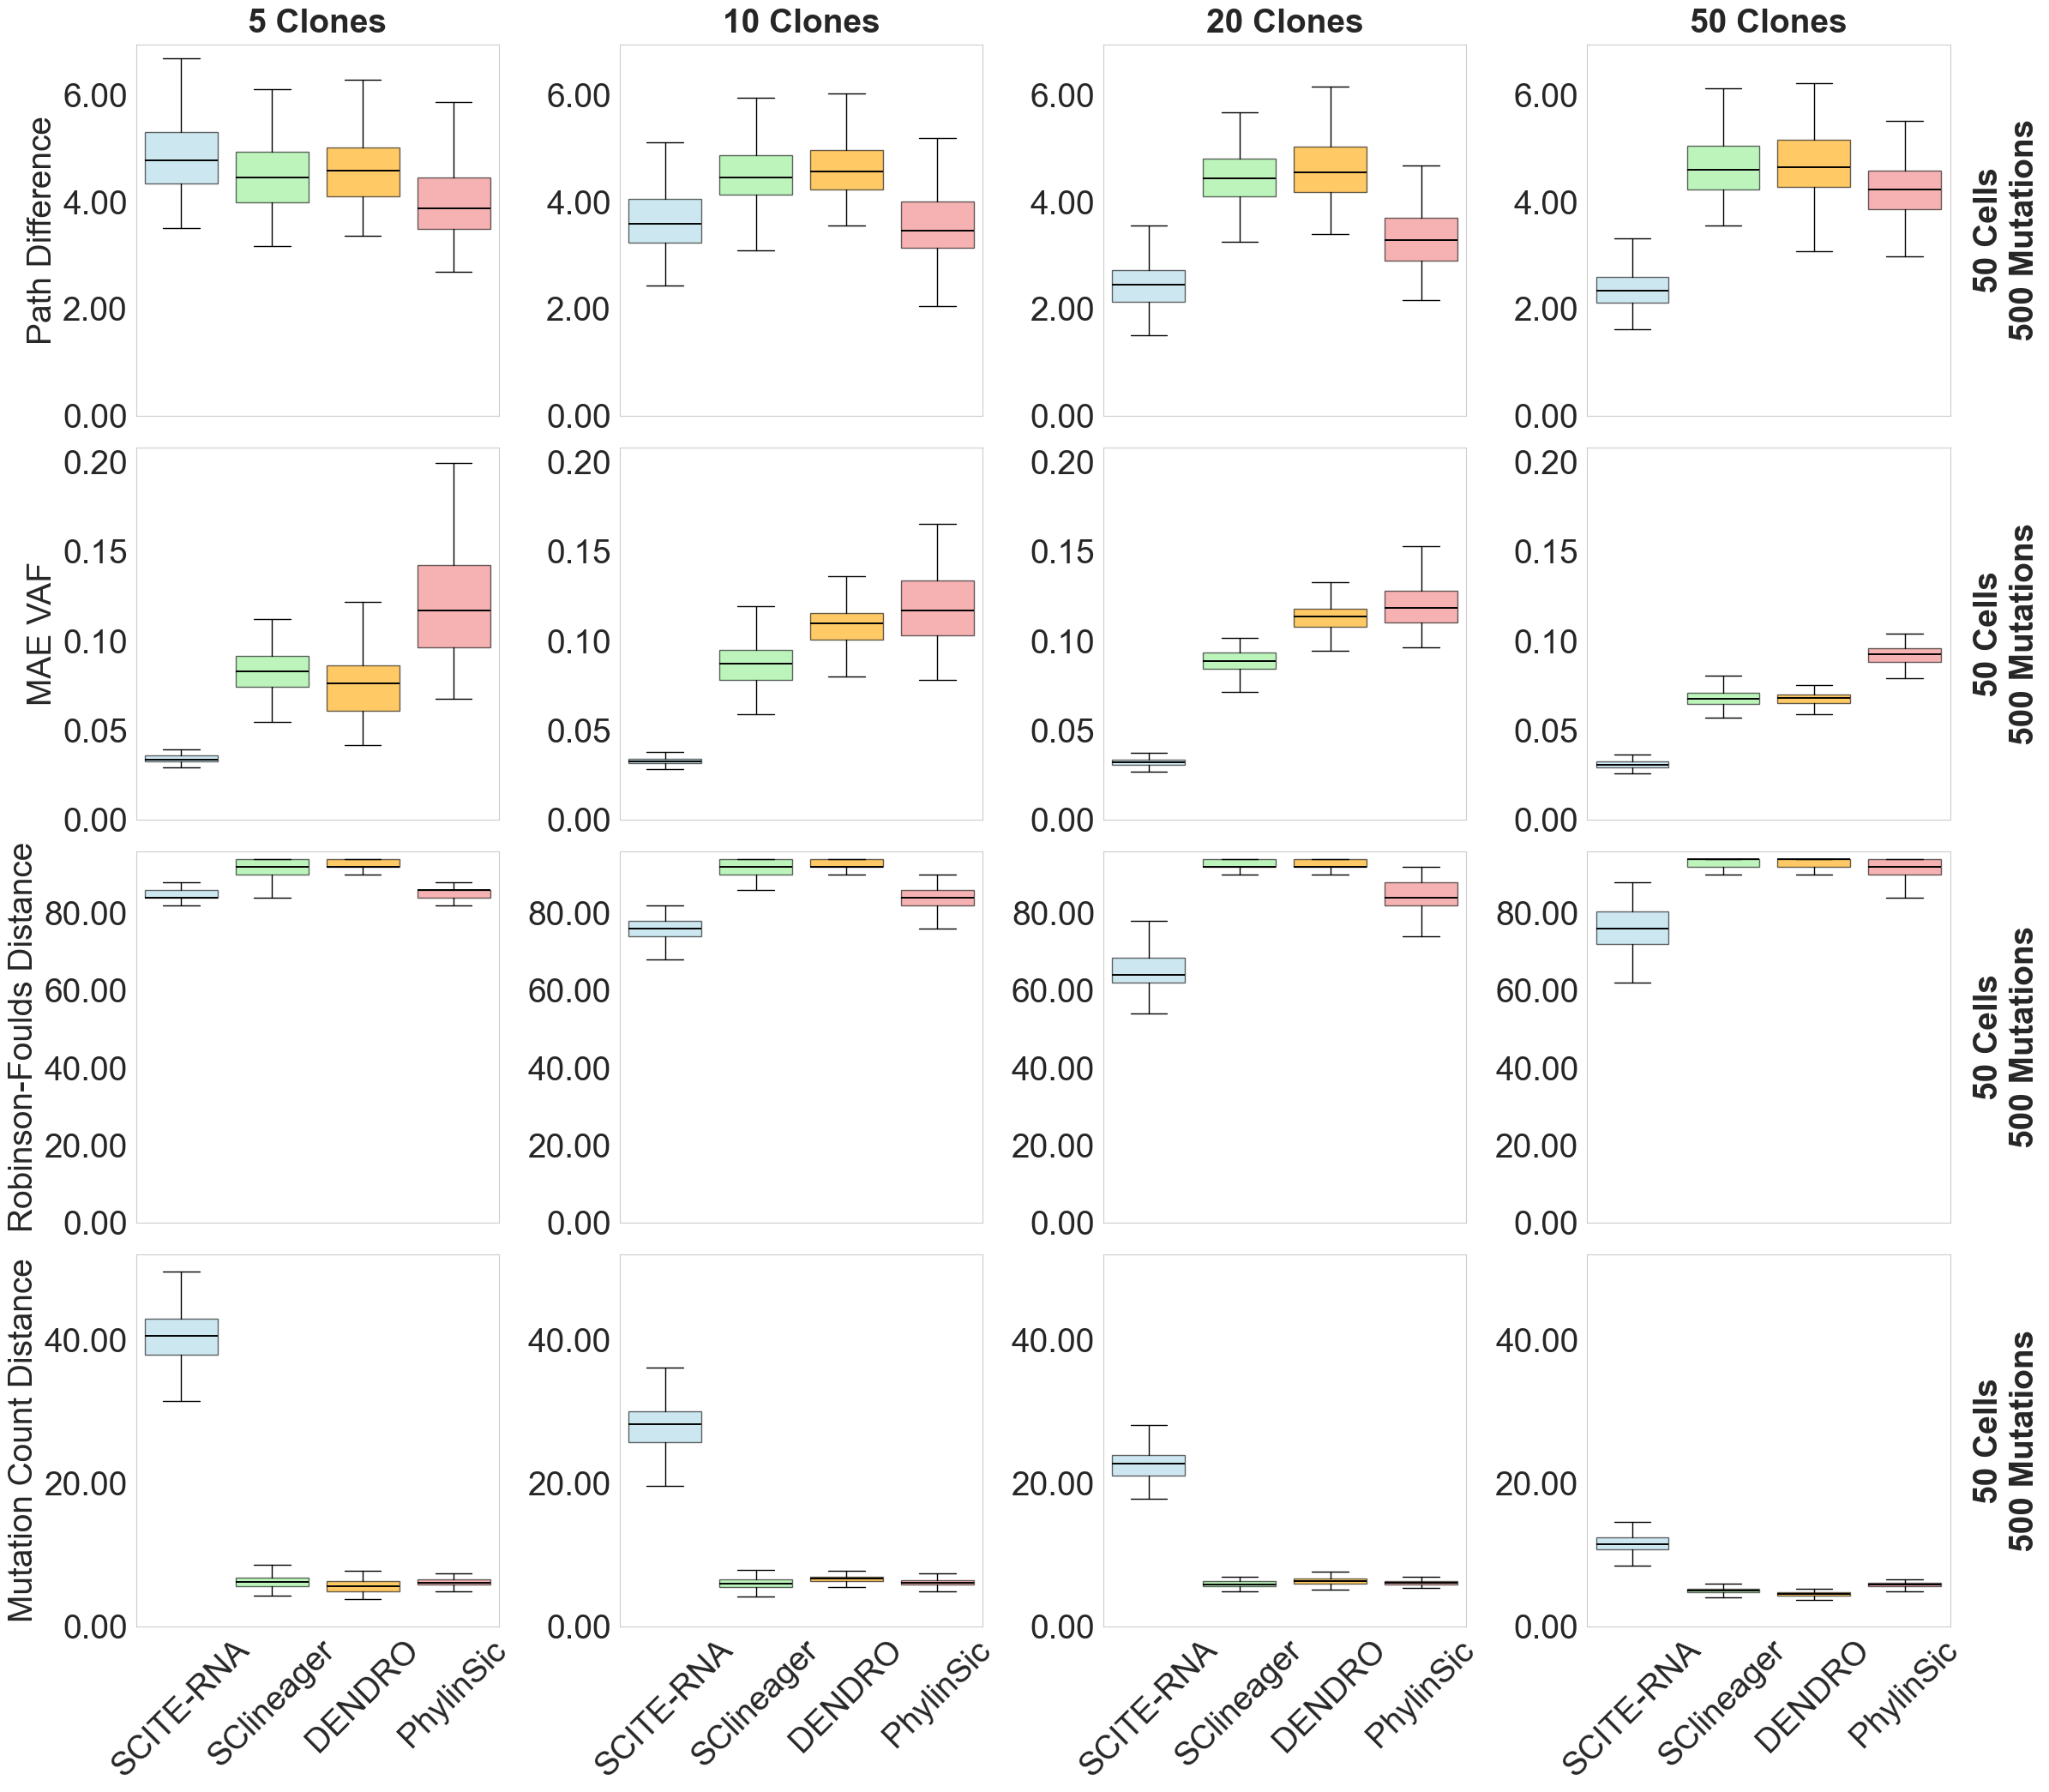

In [111]:
def plot_combined_vaf_pathlength(data_list, clones, models=["SCITE-RNA", "SClineager", "DENDRO", "PhylinSic"]):

    n_c, n_m = 50, 500  # fixed cell and mutation counts
    rows = len(data_list)
    cols = len(clones)

    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows + 1), sharey=False)
    if rows == 1:
        axes = np.expand_dims(axes, axis=0)

    colors = ["lightblue", "lightgreen", "orange", "lightcoral"]
    alpha_value = 0.6

    title_size = 28
    label_size = 28
    tick_size = 28
    box_width = 1.4
    boxplot_widths = 0.8

    plot_titles = ["Path Difference", "MAE VAF", "Robinson-Foulds Distance", "Mutation Count Distance"]
    # data_list = [pathlen_data, vaf_data]

    for row_idx, (data, plot_title) in enumerate(zip(data_list, plot_titles)):
        row_whiskers = []

        for col_idx, clone in enumerate(clones):
            sample_key = f"{n_c}_{n_m}"
            all_samples = [data[model][sample_key][clone] for model in models]

            ax = axes[row_idx, col_idx]
            box = ax.boxplot(all_samples, patch_artist=True, widths=boxplot_widths, showfliers=False)

            for patch, color in zip(box['boxes'], colors):
                patch.set_facecolor(color)
                patch.set_alpha(alpha_value)

            for line in box['medians']:
                line.set_linewidth(box_width)
                line.set_color("black")

            whisker_data = np.concatenate([line.get_ydata() for line in box['whiskers']])
            row_whiskers.append(whisker_data)

            if row_idx == 0:
                if clone == "":
                    ax.set_title("50 Clones", fontsize=title_size, pad=10, fontweight="bold")
                else:
                    ax.set_title(f"{clone} Clones", fontsize=title_size, pad=10, fontweight="bold")

            if row_idx == rows - 1:
                ax.set_xticklabels(models, fontsize=tick_size)
            else:
                ax.set_xticks([])

            if col_idx == 0:
                ax.set_ylabel(plot_title, fontsize=label_size)
            if col_idx == cols - 1:
                ax.yaxis.set_label_position("right")
                ax.set_ylabel(f"{n_c} Cells\n{n_m} Mutations",
                              fontsize=label_size,
                              rotation=90, labelpad=20,
                              fontproperties=FontProperties(weight='bold'))

            ax.tick_params(axis='x', labelsize=tick_size, rotation=45)
            ax.tick_params(axis='y', labelsize=tick_size)
            ax.grid(False)
            ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))

        # Apply uniform y-limits across each row
        combined = np.concatenate(row_whiskers)
        ymin, ymax = combined.min(), combined.max()
        yrange = ymax - ymin
        ymin = 0
        ymax += 0.05 * yrange

        if np.isfinite(ymin):
            for col_idx in range(cols):
                axes[row_idx, col_idx].set_ylim(ymin, ymax)

    plt.tight_layout()
    # plt.savefig("../data/results/figures/Figure_Path_VAF.pdf")
    plt.show()

plot_combined_vaf_pathlength([path_len_differences, genotype_differences, rf_differences, mut_count_differences], ["5", "10", "20", ""])

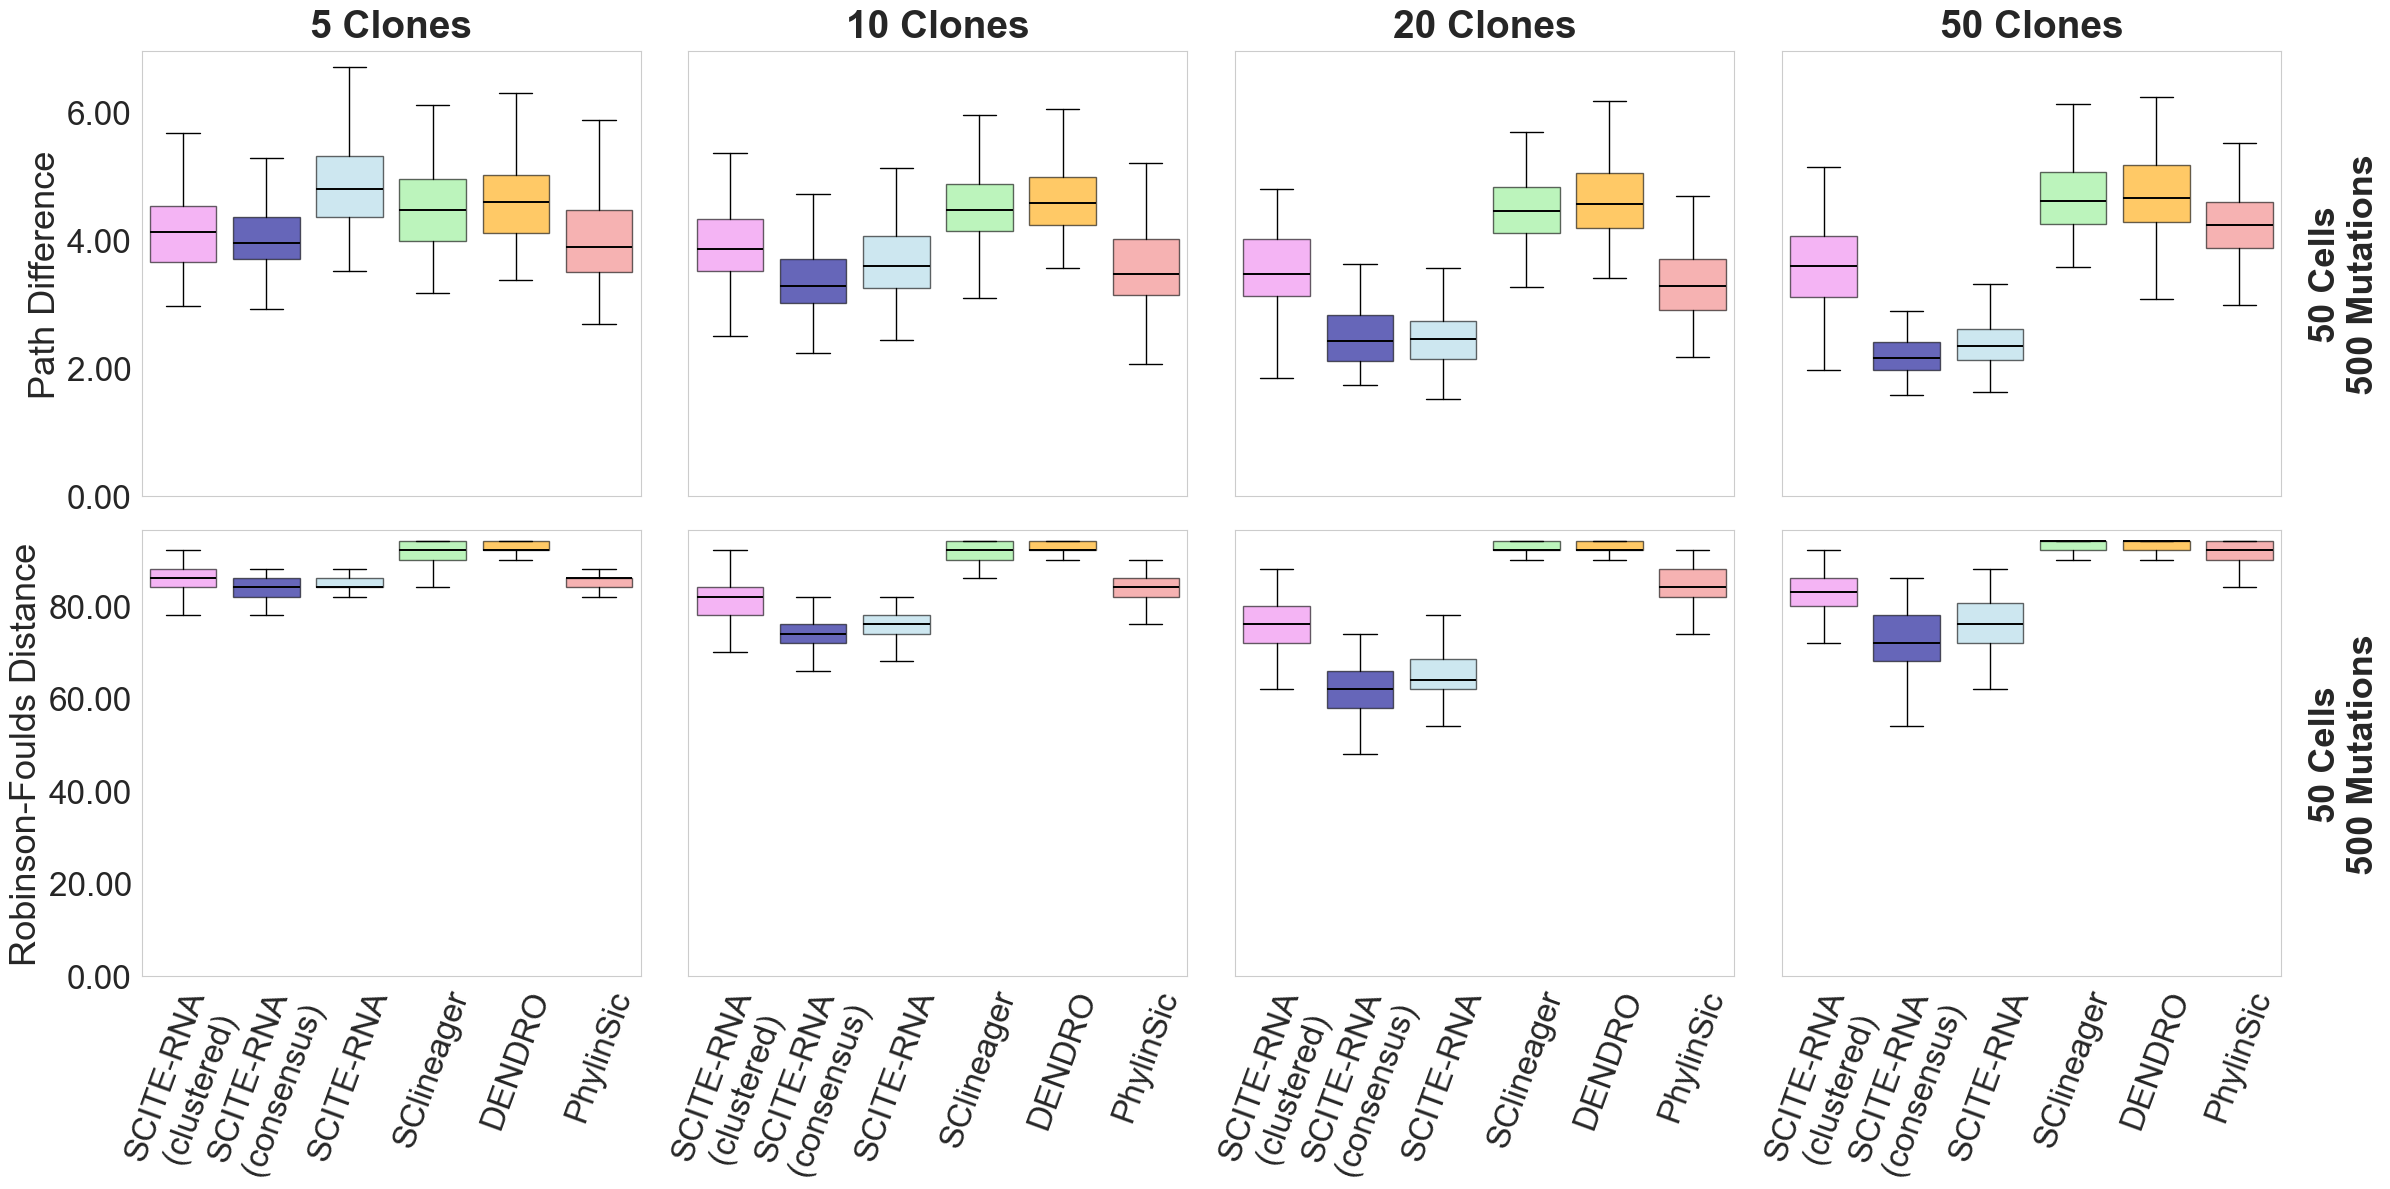

In [109]:
def plot_combined_vaf_pathlength(datasets, clones, models=["SCITE-RNA-clustered", "SCITE-RNA-consensus", "SCITE-RNA", "SClineager", "DENDRO", "PhylinSic"]):
    n_c, n_m = 50, 500
    n_datasets = len(datasets)
    cols = len(clones)
    fig, axes = plt.subplots(n_datasets, cols, figsize=(6 * cols, 6 * n_datasets), sharey='row', sharex=True)
    if n_datasets == 1:
        axes = np.expand_dims(axes, axis=0)
    if cols == 1:
        axes = np.expand_dims(axes, axis=1)

    colors = ["violet", "darkblue", "lightblue", "lightgreen", "orange", "lightcoral"]
    alpha_value = 0.6
    title_size = 28
    label_size = 26
    tick_size = 24
    box_width = 1.4
    boxplot_widths = 0.8
    row_whiskers = [[] for _ in range(n_datasets)]

    for dataset_idx, dataset in enumerate(datasets):
        for col_idx, clone in enumerate(clones):
            sample_key = f"{n_c}_{n_m}"
            all_samples = [dataset[model][sample_key][clone] for model in models]
            ax = axes[dataset_idx, col_idx]

            # Plot boxplots
            box = ax.boxplot(all_samples, patch_artist=True, widths=boxplot_widths, showfliers=False)
            for patch, color in zip(box['boxes'], colors):
                patch.set_facecolor(color)
                patch.set_alpha(alpha_value)
            for line in box['medians']:
                line.set_linewidth(box_width)
                line.set_color("black")

            whisker_data = np.concatenate([line.get_ydata() for line in box['whiskers']])
            row_whiskers[dataset_idx].append(whisker_data)

            custom_labels = [
                "SCITE-RNA\n(clustered)",
                "SCITE-RNA\n(consensus)",
                "SCITE-RNA",
                "SClineager",
                "DENDRO",
                "PhylinSic"
            ]
            ax.set_xticks(range(1, len(models) + 1))
            ax.set_xticklabels(custom_labels, fontsize=tick_size, rotation=70, ha='center', va='top')

            if dataset_idx == 0:
                if clone == "":
                    ax.set_title("50 Clones", fontsize=title_size, pad=10, fontweight="bold")
                else:
                    ax.set_title(f"{clone} Clones", fontsize=title_size, pad=10, fontweight="bold")

            ax.tick_params(axis='y', labelsize=tick_size)
            ax.grid(False)
            ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))

            # Add y-axis label only to the first subplot of each row
            if col_idx == 0:
                if dataset_idx == 0:
                    ax.set_ylabel("Path Difference", fontsize=label_size)
                else:
                    ax.set_ylabel("Robinson-Foulds Distance", fontsize=label_size)

            # Add cell/mutation info to the last subplot of each row
            if col_idx == cols - 1:
                ax.yaxis.set_label_position("right")
                ax.set_ylabel(f"{n_c} Cells\n{n_m} Mutations",
                              fontsize=label_size,
                              rotation=90, labelpad=20,
                              fontproperties=FontProperties(weight='bold'))

    # Uniform y-axis limits for each row
    for dataset_idx in range(n_datasets):
        combined = np.concatenate(row_whiskers[dataset_idx])
        ymin, ymax = combined.min(), combined.max()
        yrange = ymax - ymin
        ymin = 0
        ymax += 0.05 * yrange
        for col_idx in range(cols):
            axes[dataset_idx, col_idx].set_ylim(ymin, ymax)

    plt.tight_layout()
    # Uncomment to save the figure
    # plt.savefig("../data/results/figures/Figure_clustering_consensus_Path_RF.pdf")
    plt.show()

# Example usage:
plot_combined_vaf_pathlength([path_len_differences, rf_differences], ["5", "10", "20", ""])

Error loading data for 50c 50m: ../data/simulated_data/50c50m\sciterna\sciterna_runtimes.txt not found.
Error loading data for 50c 100m: ../data/simulated_data/50c100m\sciterna\sciterna_runtimes.txt not found.
Error loading data for 100c 50m: ../data/simulated_data/100c50m\sciterna\sciterna_runtimes.txt not found.
Error loading data for 100c 100m: ../data/simulated_data/100c100m\sciterna\sciterna_runtimes.txt not found.
Error loading data for 100c 200m: ../data/simulated_data/100c200m\sciterna\sciterna_runtimes.txt not found.
Error loading data for 200c 100m: ../data/simulated_data/200c100m\sciterna\sciterna_runtimes.txt not found.
Error loading data for 200c 200m: ../data/simulated_data/200c200m\sciterna\sciterna_runtimes.txt not found.


IndexError: list index out of range

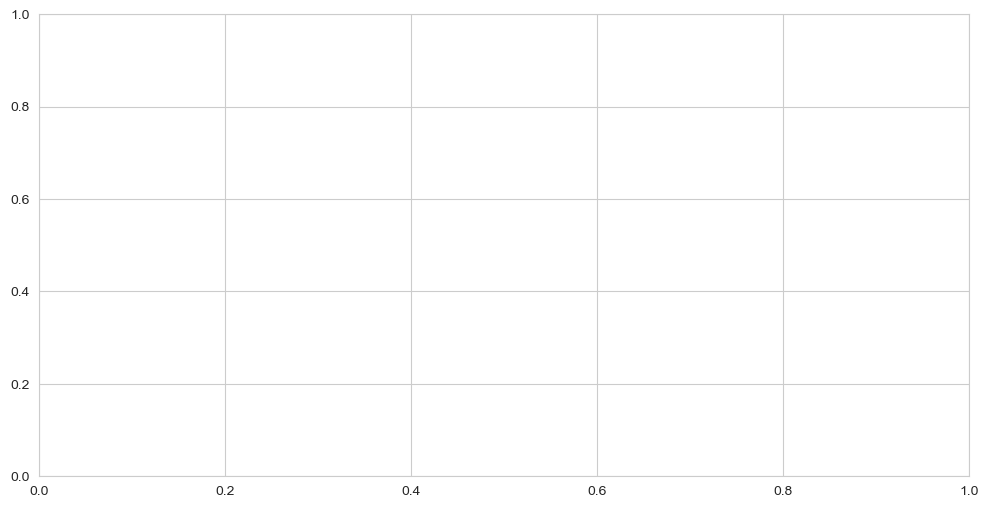

In [95]:
n_cells = [50, 50, 100, 100, 100, 200, 200]
n_mut = [50, 100, 50, 100, 200, 100, 200]
path = "../data/simulated_data/"
clone = ""

models = ["SClineager", "SCITE-RNA", "DENDRO"]
colors = ["lightgreen", "lightblue", "orange"]

conditions = []
for n_c, n_m in zip(n_cells, n_mut):
    condition_label = f"{n_c}c {n_m}m"
    conditions.append(condition_label)

if not use_summary_statistics:
    runtime_data = {model: [] for model in models}
    for n_c, n_m in zip(n_cells, n_mut):
        condition_label = f"{n_c}c {n_m}m"

        base_path = os.path.join(path, f"{n_c}c{n_m}m{clone}")
        try:
            scite_rna = np.loadtxt(os.path.join(base_path, "sciterna", "sciterna_runtimes.txt"))
            sclineager = np.loadtxt(os.path.join(base_path, "sclineager", "sclineager_runtimes.txt"))
            dendro = np.loadtxt(os.path.join(base_path, "dendro", "dendro_runtimes.txt"))
        except Exception as e:
            print(f"Error loading data for {condition_label}: {e}")
            continue

        runtime_data["SCITE-RNA"].append(scite_rna)
        runtime_data["SClineager"].append(sclineager)
        runtime_data["DENDRO"].append(dendro)

fig, ax = plt.subplots(figsize=(12, 6))

positions = []
box_data = []
group_spacing = 2
box_width = 1.2

tick_positions = []
tick_labels = []

for idx, condition in enumerate(conditions):
    group_positions = []
    for offset, model in enumerate(models):
        pos = idx * group_spacing # + offset
        positions.append(pos)
        group_positions.append(pos)
        box_data.append(runtime_data[model][idx])

    tick_center = np.mean(group_positions)
    tick_positions.append(tick_center)
    tick_labels.append(condition)

# Plot boxplots
box = ax.boxplot(box_data, positions=positions, widths=box_width, patch_artist=True, showfliers=False)

for patch, color in zip(box["boxes"], [colors[i % 3] for i in range(len(box_data))]):
    patch.set_facecolor(color)
    patch.set_edgecolor(color)
    patch.set_alpha(0.7)

for line in box['medians']:
    line.set_color("black")
    line.set_linewidth(1.0)

ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=0, ha='center', fontsize=15)
ax.set_ylabel("Runtime (log seconds)", fontsize=16)
ax.set_yscale("log")
ax.tick_params(axis='y', labelsize=12)
ax.grid(False)

reference_lines = [0.1, 1, 10, 100]
for y in reference_lines:
    ax.axhline(y=y, color='gray', linestyle='--', linewidth=0.7)
    ax.text(len(conditions)*group_spacing - 1, y, f'{y}s', va='bottom', ha='right', fontsize=12, color='gray', zorder=1)

legend_patches = [Patch(facecolor=colors[i], edgecolor=colors[i], label=models[i]) for i in range(len(models))]
ax.legend(handles=legend_patches, title="Models", loc='upper left', fontsize=13, title_fontsize=15, facecolor='white', framealpha=1.0, edgecolor='black')

plt.tight_layout()
plt.savefig("../data/results/figures/Figure_model_runtime_comparison.pdf")
plt.show()